# PyTorch Intro (Autograd + First MLP) + DataLoader


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

print('torch:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


torch: 2.9.0+cpu
device: cpu


## 1) Autograd quick demo

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y = x**2 + 3*x + 1
y.backward()
print('y:', y.item())
print('dy/dx:', x.grad.item())


y: 11.0
dy/dx: 7.0


## 2) Dataset: 2D blobs

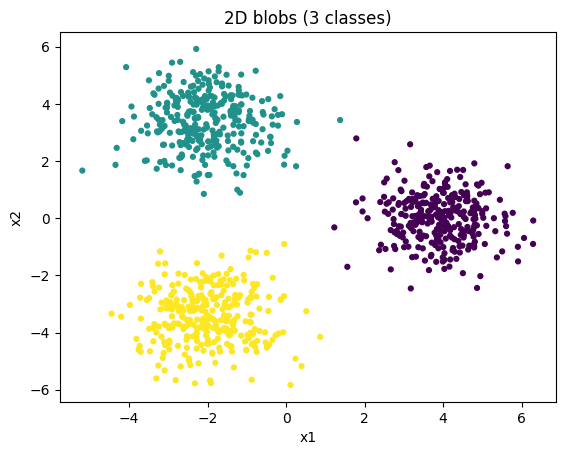

In [ ]:
def make_blobs(n=900, centers=3, std=0.9, seed=1):
    rng = np.random.default_rng(seed)
    angles = np.linspace(0, 2*np.pi, centers, endpoint=False)
    radius = 4.0
    means = np.c_[radius*np.cos(angles), radius*np.sin(angles)]
    X = []
    y = []
    per = n // centers
    for k in range(centers):
        pts = rng.normal(loc=means[k], scale=std, size=(per, 2))
        X.append(pts)
        y.append(np.full(per, k))
    X = np.vstack(X).astype(np.float32)
    y = np.concatenate(y).astype(np.int64)
    idx = rng.permutation(len(y))
    return X[idx], y[idx]

X_np, y_np = make_blobs(n=900, centers=3, std=0.9, seed=1)
plt.figure(); plt.scatter(X_np[:,0], X_np[:,1], c=y_np, s=12);
plt.title('2D blobs (3 classes)'); plt.xlabel('x1'); plt.ylabel('x2'); plt.show()

split = int(0.8 * len(y_np))
X_train_np, X_test_np = X_np[:split], X_np[split:]
y_train_np, y_test_np = y_np[:split], y_np[split:]

# Keep train set on CPU for the DataLoader; move each batch to GPU inside the loop.
X_train_cpu = torch.tensor(X_train_np)
y_train_cpu = torch.tensor(y_train_np)
X_test = torch.tensor(X_test_np, device=device)
y_test = torch.tensor(y_test_np, device=device)


## 4) Model: small MLP (logits output)

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=16, out_dim=3, dropout_p=0.0, use_bn=False):
        super().__init__()

        # TODO: Build the network using nn.Sequential

        self.net = None  # TODO: replace with nn.Sequential(...)

        raise NotImplementedError("TODO: implement self.net")

    def forward(self, x):
        # TODO: run forward pass through self.net
        raise NotImplementedError("TODO: implement forward")

# TODO: instantiate and move to device
model = MLP(in_dim=2, hidden=16, out_dim=3, dropout_p=0.3, use_bn=True).to(device)
print(model)


## 5) Training loop using DataLoader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# =========================
# TODO 1) Loss + Optimizer
# =========================

# TODO: define the criterion for multiclass classification
criterion = None

# TODO: define the optimizer

# Hint: optim.SGD(model.parameters(), lr=..., weight_decay=...)
optimizer = None


# =========================
# TODO 2) Accuracy function
# =========================


def accuracy_from_logits(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

# =========================
# TODO 3) Training loop with DataLoader
# =========================
def train_with_loader(model, train_loader, X_test, y_test, epochs=60, weight_decay=0.0):
    """
    Train using mini-batches from a DataLoader.

    TODO requirements:

    - return a dict history with keys: 'loss', 'train_acc', 'test_acc'
    """
    history = {"loss": [], "train_acc": [], "test_acc": []}

    # TODO: initialize criterion + optimizer (SGD, lr=0.05, weight_decay=weight_decay)


    raise NotImplementedError("TODO: implement train_with_loader")


# =========================
# (Optional) Smoke test call
# =========================
# history = train_with_loader(model, train_loader, X_test, y_test, epochs=60, weight_decay=0.0)


In [ ]:
train_ds = TensorDataset(X_train_cpu, y_train_cpu)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)

xb, yb = next(iter(train_loader))
print('batch X:', xb.shape, xb.device)
print('batch y:', yb.shape, yb.device)
history = train_with_loader(model, train_loader, X_test, y_test, epochs=60)

plt.figure(); plt.plot(history['loss']); plt.xlabel('epoch'); plt.ylabel('train loss'); plt.show()
plt.figure(); plt.plot(history['train_acc'], label='train'); plt.plot(history['test_acc'], label='test');
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.show()

## Adam and AdamW (mathematical view)

### Setup and notation
We minimize an objective $f(\theta)$ with parameters $\theta \in \mathbb{R}^d$.
At step $t$, the stochastic gradient is

$$
g_t = \nabla_{\theta} f_t(\theta_{t-1})
$$

Adam maintains **exponential moving averages** of:
- the first moment (mean) of gradients $m_t$
- the second moment (uncentered variance) $v_t$

Hyperparameters:
- learning rate $\alpha > 0$
- $\beta_1 \in [0,1)$ (momentum for the mean)
- $\beta_2 \in [0,1)$ (momentum for the second moment)
- $\epsilon > 0$ (numerical stability)

Initialize

$$
m_0 = 0,\quad v_0 = 0
$$

---

## Adam

### Moment updates
First moment:

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1)\, g_t
$$

Second moment:

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)\, (g_t \odot g_t)
$$

where $\odot$ is elementwise multiplication.

### Bias correction
Because $m_0, v_0$ start at zero, early estimates are biased toward zero. Adam uses:

$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t}
$$

$$
\hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$

### Parameter update
Adam updates parameters with an elementwise adaptive step size:

$$
\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

**Interpretation (intuition):**
- $\hat{m}_t$ is a momentum-smoothed gradient direction.
- $\sqrt{\hat{v}_t}$ scales each parameter’s step inversely with recent gradient magnitude.
- Coordinates with consistently large gradients get smaller effective step sizes.

---

## L2 regularization vs weight decay (important distinction)

If we add L2 regularization to the objective:

$$
f(\theta) + \frac{\lambda}{2}\|\theta\|^2
$$

then the gradient becomes:

$$
g_t \leftarrow g_t + \lambda \theta_{t-1}
$$

For plain SGD, this is equivalent to *weight decay*.  
For Adam, this is **not equivalent** to decaying weights directly, because Adam rescales gradients by $\sqrt{\hat{v}_t}$. This motivates AdamW.

---

## AdamW (decoupled weight decay)

AdamW keeps the Adam moment estimates based on the **data gradient** $g_t$ (without adding $\lambda \theta$ into $g_t$), and applies weight decay as a **separate** shrinkage step.

### Moments (same as Adam)
Compute moments from the data gradient $g_t$:

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1)\, g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)\, (g_t \odot g_t)
$$

Bias-correct:

$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t},\quad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$

### Decoupled update
AdamW performs:

$$
\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \alpha \lambda \theta_{t-1}
$$

Equivalently:

$$
\theta_t = (1-\alpha \lambda)\theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

**Key point:** the weight-decay term $\alpha \lambda \theta_{t-1}$ is **not** divided by $\sqrt{\hat{v}_t}$.  
So regularization strength is applied consistently across parameters, independent of Adam’s adaptive scaling.

---

## Summary (what changes from Adam to AdamW)

### Adam with L2-as-gradient-penalty (coupled)
Uses:

$$
g_t \leftarrow g_t + \lambda \theta_{t-1}
$$

and then applies the Adam update, meaning the regularization term is also adaptively scaled by $\sqrt{\hat{v}_t}$.

### AdamW (decoupled)
Uses Adam moments from the data gradient $g_t$ and applies weight decay separately:

$$
\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \alpha \lambda \theta_{t-1}
$$

---

## Common default hyperparameters (for reference)
Typical values used in practice:

$$
\beta_1 = 0.9,\quad \beta_2 = 0.999,\quad \epsilon = 10^{-8}
$$

(learning rate $\alpha$ and weight decay $\lambda$ depend on the task and model)


## Dropout (mathematical view) and why it acts like regularization

### Definition (inverted dropout)
Let $x \in \mathbb{R}^d$ be an input (or a hidden activation vector).  
Let $q \in (0,1]$ be the **keep probability** (so dropout probability is $p = 1-q$).

Sample a mask elementwise:

$$
r_j \sim \text{Bernoulli}(q), \quad j=1,\dots,d
$$

Apply **inverted dropout** (the standard in modern libraries):

$$
\tilde{x} = \frac{r \odot x}{q}
$$

so that

$$
\mathbb{E}[\tilde{x}] = x
$$

At **training time**, we use $\tilde{x}$.  
At **test time**, dropout is turned off and we use $x$.

---

### Dropout as (approximate) regularization: a clean derivation for squared loss
Consider a linear model with squared loss on one example:

$$
\hat{y} = w^\top \tilde{x}, \quad \ell(w) = (y - w^\top \tilde{x})^2
$$

Define the random variable:

$$
z = w^\top \tilde{x} = \sum_{j=1}^d w_j \frac{r_j x_j}{q}
$$

Because the $r_j$ are independent:

$$
\mathbb{E}[z] = w^\top x
$$

and

$$
\text{Var}(z) = \sum_{j=1}^d (w_j x_j)^2 \, \text{Var}\!\left(\frac{r_j}{q}\right)
= \sum_{j=1}^d (w_j x_j)^2 \, \frac{1}{q^2}\, q(1-q)
= \frac{1-q}{q}\sum_{j=1}^d (w_j x_j)^2
$$

Using $\mathbb{E}[(y-z)^2] = (y-\mathbb{E}[z])^2 + \text{Var}(z)$, we get:

$$
\mathbb{E}\big[(y - w^\top \tilde{x})^2\big]
= (y - w^\top x)^2 + \frac{1-q}{q}\sum_{j=1}^d (w_j x_j)^2
$$

That second term is a **penalty on the weights**. Over a dataset, averaging over samples gives:

$$
\mathbb{E}_{\text{dropout}}\Big[\frac{1}{N}\sum_{i=1}^N (y_i - w^\top \tilde{x}_i)^2\Big]
= \frac{1}{N}\sum_{i=1}^N (y_i - w^\top x_i)^2
+ \frac{1-q}{q}\sum_{j=1}^d w_j^2 \Big(\frac{1}{N}\sum_{i=1}^N x_{ij}^2\Big)
$$

So for squared loss, dropout is **exactly equivalent** to adding an **L2-like regularizer** with
feature-dependent strength:

$$
\lambda_j = \frac{1-q}{q}\Big(\frac{1}{N}\sum_{i=1}^N x_{ij}^2\Big)
$$

This is why we say dropout behaves like regularization: it discourages large weights, and the effect increases as dropout becomes stronger (smaller $q$).

---

### Intuition (beyond squared loss)
For deep networks and other losses, the equivalence is not exact, but dropout still acts as **stochastic regularization**:
- it injects multiplicative noise,
- prevents co-adaptation of units,
- behaves like training an ensemble of many “thinned” subnetworks and averaging them at test time.


## Batch Normalization (BatchNorm): what it is and why we use it

### Goal
BatchNorm stabilizes and speeds up training by normalizing activations inside the network.
It reduces sensitivity to initialization and learning rate, and often improves optimization.

---

### Definition (for a mini-batch)
Let $h \in \mathbb{R}^{N \times d}$ be a batch of pre-activation values (or activations) for one layer:
- $N$ = batch size
- $d$ = number of features (neurons/channels)

Compute per-feature batch statistics:

$$
\mu_B = \frac{1}{N}\sum_{i=1}^{N} h_i
$$

$$
\sigma_B^2 = \frac{1}{N}\sum_{i=1}^{N} (h_i - \mu_B)^2
$$

Normalize:

$$
\hat{h}_i = \frac{h_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

Then apply a learnable scale and shift (so the layer can represent the identity if needed):

$$
y_i = \gamma \odot \hat{h}_i + \beta
$$

where $\gamma, \beta \in \mathbb{R}^{d}$ are trainable parameters.

---

### Training vs inference
During training, BatchNorm uses mini-batch statistics $(\mu_B, \sigma_B^2)$.

During inference, BatchNorm uses running averages of mean and variance (estimated during training), often denoted:

$$
\mu_{\text{run}},\quad \sigma^2_{\text{run}}
$$

So inference uses:

$$
\hat{h} = \frac{h - \mu_{\text{run}}}{\sqrt{\sigma^2_{\text{run}} + \epsilon}}
$$

---

### Why BatchNorm helps (intuition)
1. **Smoother optimization**: normalization keeps activation scales more consistent across layers, which makes gradients behave better.
2. **Allows larger learning rates**: training is less likely to explode or vanish due to scale issues.
3. **Less sensitivity to initialization**: you don’t need “perfect” init as much.
4. **Often improves generalization**: batch noise can act like a mild regularizer (but it is not a direct substitute for dropout).

---

### Common practice notes
- A typical block is: Linear → BatchNorm → ReLU → Dropout
- For classification with `CrossEntropyLoss`, still output logits (no softmax in the model).
- BatchNorm relies on batch statistics; very small batch sizes can make it unstable.
